In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)


In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [12]:
from dask.distributed import Client

client = Client("tcp://10.32.2.181:46299")
client

Client Scheduler: tcp://10.32.2.181:46299 Dashboard: /user/0000-0002-2584-2760/proxy/37801/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [13]:
latchoice=220

In [14]:
#Makes array of total volume transport above sigma=102 in the basin as a function of time
tr = (ds.LaVH3RHO[:].chunk({'time':12}).rolling(time=12).mean() * coords.dxG * ds.atl_maskS)[:, :101, latchoice, :].sum('l3_c') #at j_g = 215, up to sigma = 102
volume_over_time = tr.sum('i') 

In [15]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:300] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest, time dimension
mask=(istar_over_time.values==0)
istar1 = istar_over_time + 110

In [ ]:
istar1.load()

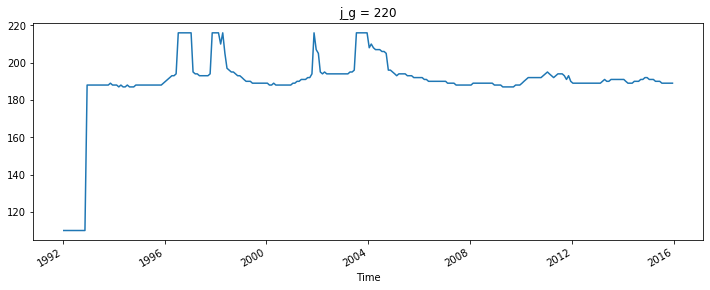

In [29]:
istar1.plot(figsize=(12,4))

In [13]:
#Ensure that the total volume at istar is the total volume on top of the band 
#volume at istar
volume_at_istar = tr.where(tr.i < istar1).sum('i')

In [14]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, latchoice, :] #(time, l3_c, i)

In [15]:
#top left and right
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])

adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])

bottom = a[:, 101:, :].sum(['l3_c', 'i'])

istar3 = istar1 + 1
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 
ratio=ratio.where(difference.values!=0,0)

In [16]:
#Compute the next cell's advection - top left  
adv_nextcell = a.where(a.i < istar3)[:, :101, :].sum(['i','l3_c'])
adv_difference = adv_nextcell - top_left 
adv_topleft = ((ratio * adv_difference + top_left)[12:]*ds.dt[12:]).cumsum('time')#ratio * adv_difference + 

In [17]:
#top right 
adv_nextcell = a.where(a.i >= istar3)[:, :101, :].sum(['i','l3_c']) 
#adv_difference = adv_nextcell - top_right
adv_topright = (((1-ratio) * adv_difference +adv_nextcell)[12:] * ds.dt[12:]).cumsum('time')#

In [18]:
a[:, :101, :].sum(['i','l3_c'])[73].values

array(9.25032834e+14)

In [19]:
#bottom
bottom = ((a[:, 101:, :].sum(['l3_c', 'i']))[12:] * ds.dt[12:]).cumsum('time')

In [20]:
tot_adv=((a.sum(['l3_c', 'i']))[12:] * ds.dt[12:]).cumsum('time')

In [21]:
#Load
adv_topright.load()

<xarray.DataArray (time: 276)>
array([ 1.05982982e+19,  2.53376154e+20,  3.29547308e+20,  1.43670085e+20,
        3.95421318e+20,  4.44761999e+20,  2.89832859e+20,  3.24099168e+20,
        1.12939952e+20,  3.57112391e+20,  2.29295072e+20, -2.93012721e+20,
       -8.33492456e+20, -8.85749287e+20, -1.00330171e+21, -1.00954368e+21,
       -8.10719730e+20, -6.89917725e+20, -7.27270131e+20, -6.94591095e+20,
       -8.07633739e+20, -6.98644363e+20, -5.18811646e+20, -6.88862765e+20,
       -1.02667397e+21, -1.24049818e+21, -1.40216821e+21, -1.28690012e+21,
       -1.20583044e+21, -1.03001746e+21, -1.10455867e+21, -1.08100826e+21,
       -1.36577450e+21, -1.33043471e+21, -9.38547657e+20, -5.87038766e+20,
       -7.14015985e+19, -1.06206580e+20,  1.71872243e+20,  4.20830943e+20,
        5.94935749e+20,  5.81846597e+20,  5.79585595e+20,  5.77584951e+20,
        5.76749423e+20,  5.77037966e+20,  5.77190767e+20,  5.80054245e+20,
        5.83030135e+20,  4.29911545e+20,  3.98144598e+20,  4.65112895e+20,
        4.57890272e+20,  4.53864643e+20,  2.72183485e+20,  1.36992046e+19,
       -2.54893763e+19,  6.34659966e+19,  6.50648688e+19,  6.65541592e+19,
        6.80606142e+19,  6.86960529e+19,  2.02130824e+19,  2.05088784e+19,
       -1.48744350e+20, -4.55152537e+20, -8.45879441e+20, -1.20614755e+21,
       -1.63668546e+21, -2.03565352e+21, -2.32650187e+21, -2.65408506e+21,
       -2.82301161e+21, -3.00641116e+21, -3.11606433e+21, -3.26986261e+21,
       -3.13449321e+21, -3.23311799e+21, -3.32509949e+21, -3.44502756e+21,
       -3.79562340e+21, -3.91950217e+21, -3.87151540e+21, -4.23034179e+21,
       -4.12701372e+21, -4.47459110e+21, -4.37590880e+21, -4.23718518e+21,
       -4.18296823e+21, -4.23503591e+21, -4.18650878e+21, -4.22767525e+21,
       -4.40295327e+21, -4.96938264e+21, -5.26704543e+21, -4.97250264e+21,
       -4.70277688e+21, -4.38833676e+21, -3.92062284e+21, -3.84897342e+21,
       -3.57072831e+21, -3.41574449e+21, -3.54834117e+21, -3.62267090e+21,
       -3.59425031e+21, -3.64652646e+21, -3.64924067e+21, -3.55034215e+21,
       -3.40491740e+21, -3.44171299e+21, -3.27958103e+21, -3.24457927e+21,
       -3.33687028e+21, -3.51645713e+21, -3.76320834e+21, -3.97558632e+21,
       -3.91121485e+21, -3.89152045e+21, -4.06355107e+21, -3.82967408e+21,
       -3.70674224e+21, -3.63827872e+21, -3.42973931e+21, -3.14051681e+21,
       -3.08371410e+21, -3.09162394e+21, -3.09409710e+21, -3.09620714e+21,
       -3.09725003e+21, -3.09746571e+21, -3.09593050e+21, -3.09412212e+21,
       -3.06011602e+21, -3.05669547e+21, -3.08512080e+21, -3.12845857e+21,
       -3.16090457e+21, -3.24808629e+21, -3.40368237e+21, -3.48881697e+21,
       -3.56236660e+21, -3.72037743e+21, -3.66759902e+21, -3.79662025e+21,
       -3.93586870e+21, -3.97106645e+21, -3.75534784e+21, -3.76850381e+21,
       -3.72526636e+21, -3.78848554e+21, -4.00979998e+21, -4.27076867e+21,
       -4.61008978e+21, -4.72493975e+21, -4.82847146e+21, -4.93233001e+21,
       -5.08418460e+21, -5.20550311e+21, -5.13749742e+21, -5.05060516e+21,
       -5.10381586e+21, -5.10407973e+21, -5.25507675e+21, -5.52601266e+21,
       -5.86614725e+21, -5.80065511e+21, -5.71391949e+21, -5.99738745e+21,
       -6.22489510e+21, -6.49331266e+21, -6.76059445e+21, -6.72858345e+21,
       -7.03024970e+21, -6.97558694e+21, -7.10286631e+21, -7.19902697e+21,
       -7.14187647e+21, -6.94426539e+21, -6.56930747e+21, -6.73492887e+21,
       -6.98244698e+21, -6.64139382e+21, -6.88953659e+21, -6.59615013e+21,
       -6.43106910e+21, -6.48479778e+21, -6.69167082e+21, -6.99437434e+21,
       -7.01608827e+21, -7.36868180e+21, -7.53626526e+21, -7.87010554e+21,
       -8.38244880e+21, -8.27906078e+21, -8.38628392e+21, -8.57975094e+21,
       -8.57628003e+21, -8.27768965e+21, -8.27243782e+21, -8.37962702e+21,
       -8.15647389e+21, -7.82460987e+21, -8.26969816e+21, -7.68780636e+21,
       -7.31410655e+21, -6.93254902e+21, -6.46403647e+21, -6.19132448e+21,
       -6.25982601e+21, -6.44922261e+21, -6.80208845e+21, -7.01574052

In [22]:
adv_topleft.load()

<xarray.DataArray (time: 276)>
array([1.54501848e+21, 3.24053408e+21, 5.01359719e+21, 6.60090714e+21,
       8.37056940e+21, 1.00546583e+22, 1.21647278e+22, 1.42748776e+22,
       1.60187399e+22, 1.80772680e+22, 1.98462735e+22, 2.18463342e+22,
       2.35756961e+22, 2.48411192e+22, 2.64984587e+22, 2.82570294e+22,
       2.98537069e+22, 3.16149372e+22, 3.32988790e+22, 3.51693964e+22,
       3.72850858e+22, 3.91119328e+22, 4.05916042e+22, 4.23473504e+22,
       4.42011830e+22, 4.56747903e+22, 4.76934295e+22, 4.97430802e+22,
       5.15854207e+22, 5.36325789e+22, 5.56695326e+22, 5.78847722e+22,
       6.01189995e+22, 6.21969381e+22, 6.40417302e+22, 6.60239977e+22,
       6.72153267e+22, 6.91598087e+22, 7.13437857e+22, 7.33272176e+22,
       7.55131341e+22, 7.75593691e+22, 7.96835916e+22, 8.17948483e+22,
       8.37957697e+22, 8.57226964e+22, 8.75967882e+22, 9.00885388e+22,
       9.24559874e+22, 9.37317813e+22, 9.58820542e+22, 9.80827435e+22,
       1.00279096e+23, 1.02526398e+23, 1.04663300e+23, 1.06781443e+23,
       1.09094091e+23, 1.11407428e+23, 1.12836344e+23, 1.14774440e+23,
       1.16557054e+23, 1.18794258e+23, 1.21110257e+23, 1.22745972e+23,
       1.25151258e+23, 1.27360695e+23, 1.29694877e+23, 1.32090503e+23,
       1.34170410e+23, 1.36541539e+23, 1.38782308e+23, 1.40337283e+23,
       1.42203705e+23, 1.44248600e+23, 1.46460093e+23, 1.48437216e+23,
       1.50374264e+23, 1.52417919e+23, 1.54441280e+23, 1.56520323e+23,
       1.58481621e+23, 1.60125635e+23, 1.62133176e+23, 1.64280193e+23,
       1.66456195e+23, 1.68292916e+23, 1.70486450e+23, 1.72290488e+23,
       1.74251381e+23, 1.76134705e+23, 1.78308693e+23, 1.80452547e+23,
       1.82466758e+23, 1.84605750e+23, 1.86846572e+23, 1.87853210e+23,
       1.89176016e+23, 1.90632746e+23, 1.92096108e+23, 1.93893485e+23,
       1.95820254e+23, 1.97691936e+23, 1.99629430e+23, 2.01673710e+23,
       2.03973266e+23, 2.05795918e+23, 2.08195558e+23, 2.10879166e+23,
       2.12192505e+23, 2.13648773e+23, 2.15382770e+23, 2.17087792e+23,
       2.18770707e+23, 2.20685647e+23, 2.22893949e+23, 2.25232412e+23,
       2.27431873e+23, 2.29457794e+23, 2.30935453e+23, 2.32699148e+23,
       2.34336813e+23, 2.35638597e+23, 2.37368530e+23, 2.39158334e+23,
       2.41024909e+23, 2.42797851e+23, 2.44740539e+23, 2.46923407e+23,
       2.49153158e+23, 2.51472228e+23, 2.53163835e+23, 2.55572521e+23,
       2.57370525e+23, 2.59675760e+23, 2.61488503e+23, 2.63475533e+23,
       2.65659913e+23, 2.67777551e+23, 2.70050742e+23, 2.71998557e+23,
       2.74049303e+23, 2.76644807e+23, 2.78975622e+23, 2.81142740e+23,
       2.83365820e+23, 2.85618401e+23, 2.87828918e+23, 2.89790510e+23,
       2.91920694e+23, 2.93943507e+23, 2.96323980e+23, 2.98738478e+23,
       3.00947328e+23, 3.02931832e+23, 3.05076924e+23, 3.07427320e+23,
       3.09405416e+23, 3.11200203e+23, 3.13181269e+23, 3.15480032e+23,
       3.17470590e+23, 3.19544111e+23, 3.21656327e+23, 3.24092827e+23,
       3.26117482e+23, 3.28191073e+23, 3.30033835e+23, 3.31752024e+23,
       3.33834935e+23, 3.35259231e+23, 3.37194348e+23, 3.39166547e+23,
       3.41085027e+23, 3.42867061e+23, 3.44704774e+23, 3.46887863e+23,
       3.49083510e+23, 3.50961092e+23, 3.52979392e+23, 3.54712349e+23,
       3.56335614e+23, 3.57899597e+23, 3.59846991e+23, 3.61457846e+23,
       3.63218047e+23, 3.65144330e+23, 3.67101049e+23, 3.69129497e+23,
       3.71292172e+23, 3.73547292e+23, 3.75830555e+23, 3.77961587e+23,
       3.79512807e+23, 3.80976339e+23, 3.82818116e+23, 3.84460880e+23,
       3.86255214e+23, 3.87942935e+23, 3.89683811e+23, 3.91478246e+23,
       3.93350094e+23, 3.94993784e+23, 3.96483997e+23, 3.98240020e+23,
       3.99939786e+23, 4.01569401e+23, 4.03441896e+23, 4.05428031e+23,
       4.07586644e+23, 4.09574869e+23, 4.11799614e+23, 4.14318867e+23,
       4.16273401e+23, 4.18106716e+23, 4.20401165e+23, 4.23090735e+23,
       4.25045491e+23, 4.26092667e+23, 4.28022821e+23, 4.29756423e+23,
       4.31641588e+23, 4.33645750e+23, 4.35604833e+23, 4.3777938

In [23]:
bottom.load()

<xarray.DataArray (time: 276)>
array([-5.37014023e+20, -1.20423990e+21, -1.83428080e+21, -2.42788123e+21,
       -3.14763731e+21, -3.80226297e+21, -4.51336580e+21, -5.21672783e+21,
       -5.80339809e+21, -6.54916695e+21, -7.10010044e+21, -7.64140670e+21,
       -8.15610388e+21, -8.63330575e+21, -9.22543998e+21, -9.86934107e+21,
       -1.05554886e+22, -1.12420564e+22, -1.19053859e+22, -1.26041604e+22,
       -1.32410077e+22, -1.38595181e+22, -1.44060789e+22, -1.49445320e+22,
       -1.55148735e+22, -1.60032507e+22, -1.66713817e+22, -1.73813212e+22,
       -1.80988662e+22, -1.88300903e+22, -1.95344471e+22, -2.02573523e+22,
       -2.09407168e+22, -2.16139263e+22, -2.22920169e+22, -2.29893579e+22,
       -2.35750094e+22, -2.42495603e+22, -2.50345432e+22, -2.57460736e+22,
       -2.65158459e+22, -2.71993891e+22, -2.79238071e+22, -2.86493758e+22,
       -2.92902317e+22, -2.99410795e+22, -3.06027403e+22, -3.13201592e+22,
       -3.19878710e+22, -3.24117711e+22, -3.31297581e+22, -3.38577855e+22,
       -3.46450750e+22, -3.54145944e+22, -3.61492131e+22, -3.68355937e+22,
       -3.75478633e+22, -3.82829863e+22, -3.88415066e+22, -3.94409591e+22,
       -4.00151140e+22, -4.07080912e+22, -4.14574320e+22, -4.20811073e+22,
       -4.28302284e+22, -4.35097434e+22, -4.42159782e+22, -4.49072169e+22,
       -4.55459810e+22, -4.62399262e+22, -4.69027838e+22, -4.73986904e+22,
       -4.79856949e+22, -4.86497062e+22, -4.93743319e+22, -5.00203256e+22,
       -5.07180062e+22, -5.14015761e+22, -5.21059937e+22, -5.28202447e+22,
       -5.33927007e+22, -5.39579208e+22, -5.45905341e+22, -5.51594204e+22,
       -5.58410218e+22, -5.63883355e+22, -5.71275142e+22, -5.77759985e+22,
       -5.84763081e+22, -5.91353337e+22, -5.98590758e+22, -6.05616754e+22,
       -6.11811120e+22, -6.17486135e+22, -6.23843201e+22, -6.28951249e+22,
       -6.34402286e+22, -6.40915624e+22, -6.47091875e+22, -6.53971919e+22,
       -6.61305516e+22, -6.68168889e+22, -6.74921681e+22, -6.81440736e+22,
       -6.88264978e+22, -6.94194327e+22, -7.01618178e+22, -7.08967491e+22,
       -7.13777249e+22, -7.19078406e+22, -7.26059458e+22, -7.32506001e+22,
       -7.38676528e+22, -7.45076540e+22, -7.51839585e+22, -7.58467691e+22,
       -7.64918033e+22, -7.71064561e+22, -7.75934172e+22, -7.81876792e+22,
       -7.88187592e+22, -7.92746071e+22, -7.99242817e+22, -8.06171888e+22,
       -8.13243197e+22, -8.19775449e+22, -8.26605514e+22, -8.33593421e+22,
       -8.40471701e+22, -8.47692794e+22, -8.53395315e+22, -8.60543829e+22,
       -8.66691336e+22, -8.73727137e+22, -8.80111284e+22, -8.87114031e+22,
       -8.94790124e+22, -9.01958526e+22, -9.09347260e+22, -9.16416020e+22,
       -9.23066533e+22, -9.30381459e+22, -9.37842187e+22, -9.44416730e+22,
       -9.51364773e+22, -9.58465257e+22, -9.65812319e+22, -9.72663415e+22,
       -9.80297004e+22, -9.87496153e+22, -9.95156999e+22, -1.00272098e+23,
       -1.00969252e+23, -1.01587577e+23, -1.02273358e+23, -1.02953883e+23,
       -1.03552192e+23, -1.04159273e+23, -1.04873840e+23, -1.05671561e+23,
       -1.06385865e+23, -1.07093064e+23, -1.07812833e+23, -1.08561983e+23,
       -1.09188529e+23, -1.09895312e+23, -1.10517135e+23, -1.11053669e+23,
       -1.11699049e+23, -1.12206217e+23, -1.12836221e+23, -1.13538353e+23,
       -1.14183158e+23, -1.14864818e+23, -1.15549828e+23, -1.16286351e+23,
       -1.17006045e+23, -1.17677193e+23, -1.18400678e+23, -1.18980624e+23,
       -1.19521040e+23, -1.20110686e+23, -1.20749257e+23, -1.21430037e+23,
       -1.22133254e+23, -1.22821487e+23, -1.23496009e+23, -1.24153778e+23,
       -1.24812424e+23, -1.25431965e+23, -1.26091514e+23, -1.26688542e+23,
       -1.27083805e+23, -1.27647926e+23, -1.28278449e+23, -1.28859724e+23,
       -1.29522911e+23, -1.30209285e+23, -1.30902085e+23, -1.31534219e+23,
       -1.32172719e+23, -1.32804005e+23, -1.33239889e+23, -1.33945397e+23,
       -1.34619789e+23, -1.35247954e+23, -1.35999320e+23, -1.36752973e+23,
       -1.37515422e+23, -1.38240710e+23, -1.38951083e+23, -1.39715919

In [24]:
#detrending
right_detrend = xr.apply_ufunc(detrend, adv_topright.load().fillna(0),kwargs={'axis': 0}).where(~adv_topright.isnull())
left_detrend= xr.apply_ufunc(detrend, adv_topleft.load().fillna(0),kwargs={'axis': 0}).where(~adv_topleft.isnull())
bottom_detrend = xr.apply_ufunc(detrend, bottom.load().fillna(0),kwargs={'axis': 0}).where(~bottom.isnull())
totadv_detrend = xr.apply_ufunc(detrend, tot_adv.load().fillna(0),kwargs={'axis': 0}).where(~bottom.isnull())

#remove season
#Removing seasons 
right_month = right_detrend.groupby('time.month').mean('time')
left_month = left_detrend.groupby('time.month').mean('time')
bottom_month = bottom_detrend.groupby('time.month').mean('time')
totadv_month = totadv_detrend.groupby('time.month').mean('time')

right_ds = right_detrend.groupby('time.month') - right_month
left_ds = left_detrend.groupby('time.month') - left_month
bottom_ds = bottom_detrend.groupby('time.month') - bottom_month
totadv_ds=totadv_detrend.groupby('time.month') - totadv_month

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


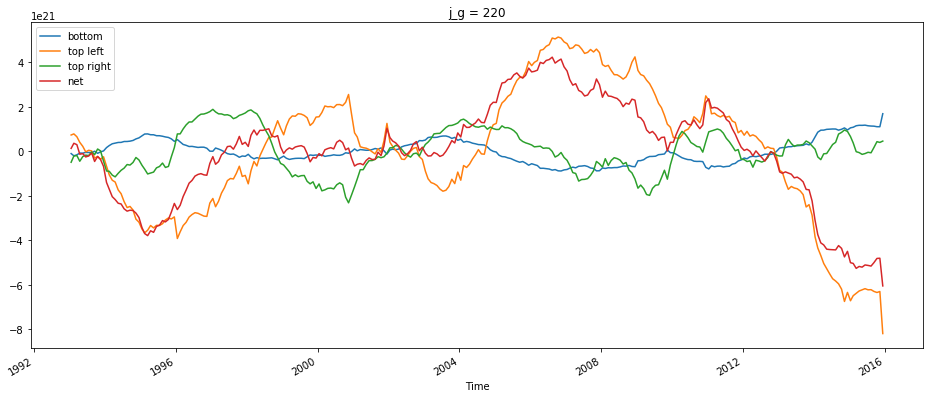

In [25]:
#detrend, mean removed
net = bottom_ds + left_ds+ right_ds
fig, ax = pltt.subplots(figsize=(16,6))
(bottom_ds).plot(ax=ax)
(left_ds).plot(ax=ax)
(right_ds).plot(ax=ax)
(net).plot(ax=ax)
#totadv_ds.plot(ax=ax)
ax.legend(("bottom", "top left", "top right", "net"),loc='upper left')

In [29]:
#Piecuch's throughflow 

v = (ds.VVELMASS[:, :, latchoice, :] * coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum(['i','k'])
t = (THETA_jg[:, :, latchoice, :] * coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum(['i','k'])
a = (coords.drF * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :] * coords.hFacS[:, latchoice, :]).sum(['i','k'])
p_throughflow = (v[12:]*t[12:]*ds.dt[12:]).cumsum('time') / a #has units of degCm^3/s- should i do a minus (v*t[time 0])? 
p_throughflow.load()

<xarray.DataArray (time: 276)>
array([-2.53937965e+13, -5.53117983e+13, -6.50674830e+13, -9.78713740e+13,
       -1.31252953e+14, -1.58140865e+14, -1.90355387e+14, -2.15855545e+14,
       -2.34578651e+14, -2.60306226e+14, -2.71632788e+14, -2.92964274e+14,
       -3.27077486e+14, -3.50850876e+14, -3.60445942e+14, -3.78201038e+14,
       -4.05898030e+14, -4.27761144e+14, -4.58671564e+14, -4.89111096e+14,
       -4.93200193e+14, -5.04868522e+14, -5.14476072e+14, -5.26867124e+14,
       -5.50650820e+14, -5.73304025e+14, -5.95346029e+14, -6.18382469e+14,
       -6.53737701e+14, -6.82319735e+14, -7.14512007e+14, -7.36381061e+14,
       -7.66605431e+14, -7.89218444e+14, -8.12032984e+14, -8.28589727e+14,
       -8.55033409e+14, -8.77825582e+14, -9.08545789e+14, -9.25486286e+14,
       -9.53673352e+14, -9.77086127e+14, -1.00250944e+15, -1.03320056e+15,
       -1.04494075e+15, -1.07062272e+15, -1.10063579e+15, -1.11556309e+15,
       -1.12773638e+15, -1.14617915e+15, -1.16943501e+15, -1.18755493e+15,
       -1.22626253e+15, -1.26081097e+15, -1.28790104e+15, -1.31224618e+15,
       -1.32620758e+15, -1.34181110e+15, -1.36605707e+15, -1.37582282e+15,
       -1.39502957e+15, -1.41823045e+15, -1.44231422e+15, -1.47130402e+15,
       -1.49790842e+15, -1.52849775e+15, -1.55628139e+15, -1.57719436e+15,
       -1.60568325e+15, -1.63297715e+15, -1.65817304e+15, -1.67803395e+15,
       -1.69014279e+15, -1.70979098e+15, -1.72789664e+15, -1.74790599e+15,
       -1.77025909e+15, -1.79584260e+15, -1.83011920e+15, -1.86423383e+15,
       -1.87356648e+15, -1.88733564e+15, -1.90203779e+15, -1.91599842e+15,
       -1.92160064e+15, -1.94908648e+15, -1.97296347e+15, -1.99175528e+15,
       -2.01802537e+15, -2.04231612e+15, -2.06392484e+15, -2.08608641e+15,
       -2.09598456e+15, -2.10617343e+15, -2.13053949e+15, -2.16423087e+15,
       -2.17149727e+15, -2.21083975e+15, -2.22033429e+15, -2.24376153e+15,
       -2.26069785e+15, -2.28175969e+15, -2.30486754e+15, -2.31285698e+15,
       -2.32674163e+15, -2.33295623e+15, -2.35219810e+15, -2.35443004e+15,
       -2.36213872e+15, -2.38739657e+15, -2.42073571e+15, -2.44653895e+15,
       -2.47028895e+15, -2.48967898e+15, -2.50666386e+15, -2.51379395e+15,
       -2.51794301e+15, -2.52426240e+15, -2.53733836e+15, -2.54960016e+15,
       -2.58180787e+15, -2.58248432e+15, -2.60516171e+15, -2.63366276e+15,
       -2.66040665e+15, -2.68545979e+15, -2.69932922e+15, -2.71563721e+15,
       -2.72810992e+15, -2.74163156e+15, -2.75525315e+15, -2.77361941e+15,
       -2.80513978e+15, -2.82781121e+15, -2.84926396e+15, -2.88272035e+15,
       -2.91734373e+15, -2.94706230e+15, -2.97104322e+15, -3.00359851e+15,
       -3.02027168e+15, -3.04726483e+15, -3.07240701e+15, -3.08915724e+15,
       -3.11837531e+15, -3.13068319e+15, -3.15319843e+15, -3.17795412e+15,
       -3.20559628e+15, -3.24047375e+15, -3.27140413e+15, -3.30223818e+15,
       -3.33470533e+15, -3.34698910e+15, -3.35876643e+15, -3.36060823e+15,
       -3.36596239e+15, -3.39493073e+15, -3.41870702e+15, -3.43559194e+15,
       -3.46287940e+15, -3.48338891e+15, -3.51359411e+15, -3.54091288e+15,
       -3.56082547e+15, -3.58566934e+15, -3.60565359e+15, -3.62197545e+15,
       -3.64166575e+15, -3.68016856e+15, -3.68977136e+15, -3.71050315e+15,
       -3.73849561e+15, -3.77219326e+15, -3.80251016e+15, -3.83379287e+15,
       -3.86143409e+15, -3.88174551e+15, -3.90353684e+15, -3.93408824e+15,
       -3.95439336e+15, -3.96173073e+15, -3.98385603e+15, -4.01162811e+15,
       -4.03453272e+15, -4.05898740e+15, -4.08875054e+15, -4.11583195e+15,
       -4.13104076e+15, -4.14130495e+15, -4.16455547e+15, -4.18190620e+15,
       -4.18915495e+15, -4.21197167e+15, -4.23804118e+15, -4.25863500e+15,
       -4.28503258e+15, -4.31372481e+15, -4.35730382e+15, -4.37527235e+15,
       -4.38256710e+15, -4.40484311e+15, -4.41369291e+15, -4.42726452e+15,
       -4.43919829e+15, -4.45505846e+15, -4.47132201e+15, -4.48550231e+15,
       -4.51457094e+15, -4.55295287e+15, -4.57693996e+15, -4.60428385

In [30]:
#Overturning
v = (ds.VVELMASS[:, :, latchoice, :] * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum('i')
t = (THETA_jg[:, :, latchoice, :] * coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :]).sum('i')
a = (coords.dxG[latchoice, :] * ds.atl_maskS[latchoice, :] * coords.hFacS[:, latchoice, :]).sum('i')
ov1 = (((v * t * coords.drF)/a).sum('k'))[12:] * ds.dt[12:]
ov = ov1.cumsum('time')
p_overturning = ov - p_throughflow  #also has units of degCm^3/s
p_overturning.load()

<xarray.DataArray (time: 276)>
array([2.33910108e+14, 5.31035736e+14, 8.09681247e+14, 1.02588083e+15,
       1.31043569e+15, 1.55219715e+15, 1.84516722e+15, 2.16295680e+15,
       2.34347441e+15, 2.66393586e+15, 2.87980088e+15, 3.11674423e+15,
       3.33344887e+15, 3.50966188e+15, 3.77201768e+15, 4.04949334e+15,
       4.30062796e+15, 4.57774680e+15, 4.80750352e+15, 5.07578154e+15,
       5.35308977e+15, 5.60707124e+15, 5.80935683e+15, 6.02916485e+15,
       6.26425007e+15, 6.48249126e+15, 6.78765872e+15, 7.09052213e+15,
       7.35377820e+15, 7.67934877e+15, 7.95608008e+15, 8.29419750e+15,
       8.57742592e+15, 8.87084413e+15, 9.16961755e+15, 9.45769641e+15,
       9.66272216e+15, 9.96886935e+15, 1.03002169e+16, 1.05954091e+16,
       1.09068628e+16, 1.11851612e+16, 1.14896165e+16, 1.17845781e+16,
       1.20424370e+16, 1.22981184e+16, 1.25655219e+16, 1.28980021e+16,
       1.31965195e+16, 1.33692554e+16, 1.36601334e+16, 1.39509629e+16,
       1.42446246e+16, 1.45390561e+16, 1.48161797e+16, 1.50628816e+16,
       1.53826267e+16, 1.56856988e+16, 1.58343659e+16, 1.60549318e+16,
       1.62798348e+16, 1.65617031e+16, 1.68656602e+16, 1.71013088e+16,
       1.74129569e+16, 1.76656422e+16, 1.79378429e+16, 1.82268795e+16,
       1.84266188e+16, 1.86888199e+16, 1.89674539e+16, 1.91332722e+16,
       1.93919641e+16, 1.96609006e+16, 1.99824060e+16, 2.02368913e+16,
       2.05062346e+16, 2.07770833e+16, 2.10414845e+16, 2.12924942e+16,
       2.14776770e+16, 2.16450237e+16, 2.19407380e+16, 2.21977848e+16,
       2.25423616e+16, 2.27808437e+16, 2.31021694e+16, 2.33663880e+16,
       2.36548879e+16, 2.39198739e+16, 2.42479985e+16, 2.45581789e+16,
       2.48142761e+16, 2.50407291e+16, 2.53155630e+16, 2.54515236e+16,
       2.56562622e+16, 2.58937651e+16, 2.61356012e+16, 2.64044782e+16,
       2.67022270e+16, 2.69837445e+16, 2.72376529e+16, 2.75104254e+16,
       2.78415415e+16, 2.80542815e+16, 2.84024908e+16, 2.87722809e+16,
       2.89498088e+16, 2.91583145e+16, 2.94244189e+16, 2.96725817e+16,
       2.99047299e+16, 3.01587005e+16, 3.04506575e+16, 3.07623633e+16,
       3.10785936e+16, 3.13294369e+16, 3.14888378e+16, 3.17278359e+16,
       3.19772021e+16, 3.21799439e+16, 3.24304145e+16, 3.26961265e+16,
       3.29667369e+16, 3.32057348e+16, 3.34793275e+16, 3.37868943e+16,
       3.40970814e+16, 3.44298840e+16, 3.46534814e+16, 3.49844867e+16,
       3.52285064e+16, 3.55170040e+16, 3.57717370e+16, 3.60625314e+16,
       3.63689713e+16, 3.66509675e+16, 3.69648162e+16, 3.72009204e+16,
       3.74834425e+16, 3.78197190e+16, 3.81553128e+16, 3.84739278e+16,
       3.87900901e+16, 3.91161347e+16, 3.94240515e+16, 3.97094013e+16,
       4.00208112e+16, 4.03040629e+16, 4.06458950e+16, 4.09868794e+16,
       4.12625171e+16, 4.15035380e+16, 4.18000633e+16, 4.21322221e+16,
       4.24118190e+16, 4.26607905e+16, 4.29328601e+16, 4.32919242e+16,
       4.35711098e+16, 4.38813011e+16, 4.41695249e+16, 4.44964046e+16,
       4.47085403e+16, 4.49815098e+16, 4.52297812e+16, 4.54221337e+16,
       4.56950415e+16, 4.58568093e+16, 4.61212515e+16, 4.63910774e+16,
       4.66278967e+16, 4.68769642e+16, 4.71131914e+16, 4.74318368e+16,
       4.77812219e+16, 4.80660539e+16, 4.84233400e+16, 4.86525464e+16,
       4.88669745e+16, 4.91361948e+16, 4.94169438e+16, 4.96864414e+16,
       4.99623955e+16, 5.02415172e+16, 5.05087779e+16, 5.07705019e+16,
       5.11020708e+16, 5.13976863e+16, 5.17394105e+16, 5.20282086e+16,
       5.21930316e+16, 5.24248687e+16, 5.27034365e+16, 5.29344499e+16,
       5.32213647e+16, 5.35099648e+16, 5.37616585e+16, 5.40074320e+16,
       5.43302965e+16, 5.45884507e+16, 5.47402783e+16, 5.50656324e+16,
       5.53447841e+16, 5.56024061e+16, 5.59156511e+16, 5.62347362e+16,
       5.65374508e+16, 5.68104230e+16, 5.70956746e+16, 5.74556662e+16,
       5.77013002e+16, 5.79453410e+16, 5.82251452e+16, 5.86435389e+16,
       5.89527149e+16, 5.91053250e+16, 5.93925562e+16, 5.96674848e+16,
       5.99567872e+16, 6.02454193e+16, 6.04928679e+16, 6.0776555

In [31]:
#Gyre
tot1 = (ds.ADVy_TH[12:, :, latchoice, :] * ds.atl_maskS[latchoice, :]*ds.dt).sum(['i','k'])
tot = tot1.cumsum('time')
p_gyre = tot - p_overturning - p_throughflow
p_gyre.load()

<xarray.DataArray (time: 276)>
array([3.93293851e+13, 8.13969574e+13, 1.09160369e+14, 1.22325912e+14,
       1.87871094e+14, 2.35491486e+14, 2.77434393e+14, 3.35781327e+14,
       4.04175124e+14, 4.88272975e+14, 5.49014639e+14, 5.61258224e+14,
       5.42708814e+14, 5.69343490e+14, 5.47164875e+14, 5.57146316e+14,
       6.03636071e+14, 6.39260086e+14, 6.79660257e+14, 7.34879255e+14,
       7.93986006e+14, 8.72203249e+14, 9.50325470e+14, 9.97722418e+14,
       1.01652277e+15, 1.00863255e+15, 1.01477416e+15, 1.08897172e+15,
       1.15448109e+15, 1.22046315e+15, 1.28203303e+15, 1.33462810e+15,
       1.38968902e+15, 1.46927953e+15, 1.57255461e+15, 1.69920828e+15,
       1.79346382e+15, 1.81063854e+15, 1.91807560e+15, 2.00987902e+15,
       2.11355065e+15, 2.18704933e+15, 2.24806582e+15, 2.32047205e+15,
       2.40507940e+15, 2.48564485e+15, 2.54329980e+15, 2.65817325e+15,
       2.78613336e+15, 2.80186745e+15, 2.87502000e+15, 2.97693355e+15,
       3.06307535e+15, 3.16178599e+15, 3.20874911e+15, 3.27187426e+15,
       3.34595843e+15, 3.46414426e+15, 3.55189718e+15, 3.66717859e+15,
       3.75589170e+15, 3.87312044e+15, 3.96264999e+15, 4.00231391e+15,
       4.07906603e+15, 4.15467619e+15, 4.21130006e+15, 4.27022779e+15,
       4.34487831e+15, 4.42098662e+15, 4.48071667e+15, 4.51274490e+15,
       4.53636722e+15, 4.57845117e+15, 4.61015585e+15, 4.66214855e+15,
       4.74965949e+15, 4.81133343e+15, 4.87975359e+15, 4.96575894e+15,
       5.04253547e+15, 5.12130824e+15, 5.18651962e+15, 5.24011468e+15,
       5.28989936e+15, 5.30806950e+15, 5.38851448e+15, 5.45801169e+15,
       5.51569937e+15, 5.56023233e+15, 5.61839682e+15, 5.67104821e+15,
       5.72157722e+15, 5.74986525e+15, 5.81752721e+15, 5.90757193e+15,
       5.96495961e+15, 6.03927732e+15, 6.12652417e+15, 6.16844050e+15,
       6.24571059e+15, 6.31138388e+15, 6.35544216e+15, 6.41136617e+15,
       6.49453047e+15, 6.57450055e+15, 6.64811594e+15, 6.77877367e+15,
       6.84686995e+15, 6.88002106e+15, 6.93875895e+15, 6.98292473e+15,
       7.01141602e+15, 7.04335666e+15, 7.08111037e+15, 7.13258245e+15,
       7.21438817e+15, 7.31804666e+15, 7.37092003e+15, 7.48563673e+15,
       7.54331184e+15, 7.56373785e+15, 7.64953441e+15, 7.74959339e+15,
       7.80166354e+15, 7.85824311e+15, 7.90442356e+15, 7.97375681e+15,
       8.05096917e+15, 8.12020818e+15, 8.18345402e+15, 8.28339882e+15,
       8.36708293e+15, 8.49180381e+15, 8.53734486e+15, 8.58255512e+15,
       8.64757267e+15, 8.71492432e+15, 8.76052747e+15, 8.83820933e+15,
       8.89163191e+15, 8.99745283e+15, 9.08544267e+15, 9.11951583e+15,
       9.17054997e+15, 9.22357784e+15, 9.34975943e+15, 9.39655830e+15,
       9.45588720e+15, 9.50915217e+15, 9.53721368e+15, 9.56701422e+15,
       9.60910589e+15, 9.68484664e+15, 9.72998741e+15, 9.78071237e+15,
       9.80524972e+15, 9.84471974e+15, 9.92113829e+15, 9.96533539e+15,
       1.00110288e+16, 1.00537364e+16, 1.00977785e+16, 1.01428590e+16,
       1.02080606e+16, 1.03084420e+16, 1.03983376e+16, 1.04408548e+16,
       1.04820612e+16, 1.05166412e+16, 1.05143283e+16, 1.05820571e+16,
       1.06097407e+16, 1.06754154e+16, 1.07190127e+16, 1.07602321e+16,
       1.08115238e+16, 1.08886367e+16, 1.09594323e+16, 1.10010300e+16,
       1.10101612e+16, 1.10683400e+16, 1.10678019e+16, 1.11237694e+16,
       1.11680739e+16, 1.12015796e+16, 1.12257292e+16, 1.12509478e+16,
       1.12952657e+16, 1.13220916e+16, 1.13579240e+16, 1.13785010e+16,
       1.13775313e+16, 1.14125123e+16, 1.14286473e+16, 1.14294354e+16,
       1.14449942e+16, 1.15013879e+16, 1.15495696e+16, 1.15784944e+16,
       1.16173206e+16, 1.17085302e+16, 1.17137939e+16, 1.17992091e+16,
       1.18724146e+16, 1.19671665e+16, 1.20569771e+16, 1.21183164e+16,
       1.21677169e+16, 1.21943404e+16, 1.22156931e+16, 1.22579434e+16,
       1.23090663e+16, 1.23650025e+16, 1.24295313e+16, 1.25668054e+16,
       1.26595543e+16, 1.26811209e+16, 1.27355531e+16, 1.27659270e+16,
       1.27932435e+16, 1.28200436e+16, 1.28221952e+16, 1.2854967

In [32]:
#detrending - piecuch
tf_detrend = xr.apply_ufunc(detrend, p_throughflow.load().fillna(0),kwargs={'axis': 0}).where(~p_throughflow.isnull())
ov_detrend = xr.apply_ufunc(detrend, p_overturning.load().fillna(0),kwargs={'axis': 0}).where(~p_overturning.isnull())
gyre_detrend = xr.apply_ufunc(detrend, p_gyre.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())
tot_detrend = xr.apply_ufunc(detrend, tot.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())

In [33]:
#Removing seasons from detrended  - piecuch
month_tf = tf_detrend.groupby('time.month').mean('time')
month_ov = ov_detrend.groupby('time.month').mean('time')
month_gyre = gyre_detrend.groupby('time.month').mean('time')
month_tot = tot_detrend.groupby('time.month').mean('time')

tf_ds = tf_detrend.groupby('time.month') - month_tf
ov_ds = ov_detrend.groupby('time.month') - month_ov
gyre_ds = gyre_detrend.groupby('time.month') - month_gyre
tot_ds = tot_detrend.groupby('time.month') - month_tot
net = bottom_ds + left_ds+ right_ds

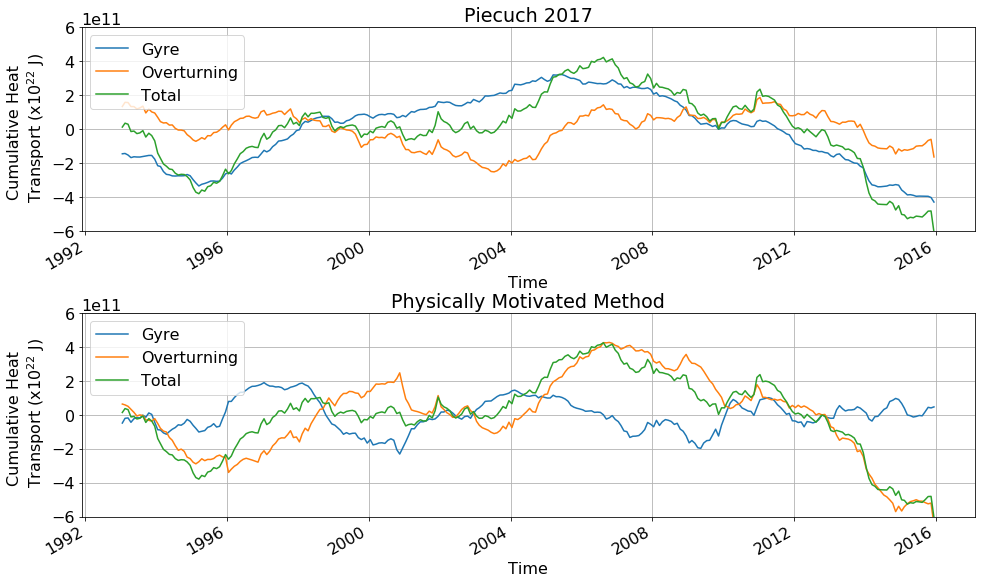

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures

In [34]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
fig, ax = pltt.subplots(figsize=(16,9))
pltt.subplot(2, 1, 1)
(gyre_ds * rho0 * cp/10**10).plot()
(ov_ds* rho0 * cp/10**10).plot()
#(tf_ds * rho0 * cp/10**10).plot(ax=ax)
(tot_ds * rho0 * cp/10**10).plot()
pltt.ylim(-0.6*10**12,0.6*10**12)
pltt.grid(True)
pltt.legend(("Gyre", "Overturning", "Total"),loc='upper left')
pltt.ylabel('Cumulative Heat \n Transport (x$10^{22}$ J)')
pltt.title('Piecuch 2017')
pltt.subplot(2, 1, 2)
(right_ds/10**10).plot()
((bottom_ds+left_ds)/10**10).plot()
#().plot(ax=ax)
(net/10**10).plot()
pltt.ylim(-0.6*10**12,0.6*10**12)
pltt.legend(("Gyre","Overturning", "Total"),loc='upper left')
pltt.ylabel('Cumulative Heat \n Transport (x$10^{22}$ J)')
pltt.title('Physically Motivated Method')
pltt.grid(True)
fig=pltt.gcf()
fig.subplots_adjust(hspace=0.4)
fig.savefig('latitude_220.pdf', bbox_inches='tight')

In [31]:
coords.YC[220][0].values

array(45.06441, dtype=float32)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures